In [27]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import EEGNet
import torch
from torch import nn as nn
from tqdm import tqdm
import wandb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from torch.utils.data import Dataset, DataLoader

verbose = 1

In [28]:
#global_configs.py
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_PROGRAM"] = "multimodal_driver.py"

DEVICE = torch.device("cuda:0")

# MOSI SETTING
ACOUSTIC_DIM = 74
VISUAL_DIM = 47
TEXT_DIM = 768

# MOSEI SETTING
# ACOUSTIC_DIM = 74
# VISUAL_DIM = 35
# TEXT_DIM = 768

XLNET_INJECTION_INDEX = 1

print mat type: <class 'dict'>
Key in mat: __header__
Key in mat: __version__
Key in mat: __globals__
Key in mat: sessionID
Key in mat: fs
Key in mat: xContinuous
Key in mat: triggers
Key in mat: onsets
 
mat xContinuous shape: (129, 1344711)
mat triggers: [[41]
 [42]
 [43]
 ...
 [73]
 [74]
 [75]]
mat onsets: [[  13917]
 [  14542]
 [  15167]
 ...
 [1284962]
 [1285587]
 [1286212]]
space between two onsets: [625]
 


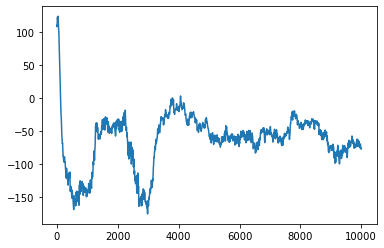

In [29]:
#Load EEG Data
mat = scipy.io.loadmat('P1_a1.mat')

#Tests to comprehend the data
if verbose == 1:
    print(f'print mat type: {type(mat)}')
    for a in mat:
        print(f'Key in mat: {a}')
    
    print(' ')
    shape = np.shape(mat['xContinuous'])
    triggers = mat['triggers']
    onsets = mat['onsets']
    
    print(f'mat xContinuous shape: {shape}')
    print(f'mat triggers: {triggers}')
    print(f'mat onsets: {onsets}')
    
    n = 1209
    subtract = mat['onsets'][n]-mat['onsets'][n-1]
    print(f'space between two onsets: {subtract}')
    print(' ')
    
    x = np.arange(0, 10000, 1)
    plt.plot(x, mat['xContinuous'][0,10000:20000])

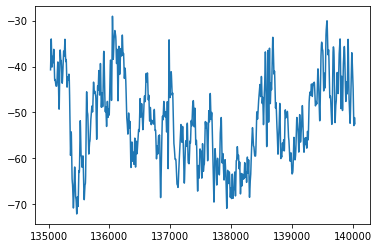

In [30]:
# Sample of framing data between two onsets
if verbose == 1:
    # Get start and end of the onsets
    start = mat['onsets'][119]
    end = mat['onsets'][124]

    # Create an x axis
    x = np.arange(start, end, 1)

    # Plot the data between onsets
    plt.plot(x, mat['xContinuous'][0,start[0]:end[0]])

In [31]:
#Find indexes d where the number is in the list ( list of deviant triggers ) 
d,j = np.where(mat['triggers'] == [30,35,40,50,55,60,70,75,80])
print(d)


#Get chunks of data from deviant trials
deviant = []

for n in d:
    start = mat['onsets'][n] #start 4 chords before
    if n == 1214:
        end = mat['onsets'][1214] + 625
    else:
        end = mat['onsets'][n+1]   #end when the next onset starts
        deviant.append(mat['xContinuous'][:,start[0]:end[0]])

#Used to print when only one channel was selected..
#a = len(deviant)
#i = 0
#while i < a:
#    x = np.arange(0, np.shape(deviant[i])[0], 1)
#    plt.plot(x, deviant[i])
#    i+=1

[  19   29   44   59   69   89  104  124  134  149  169  179  194  204
  224  244  254  269  289  299  314  334  349  359  374  384  404  424
  439  449  464  479  494  514  529  539  554  569  584  604  614  629
  644  654  674  694  709  719  739  749  764  779  799  809  829  844
  854  869  884  899  914  924  944  959  969  989 1004 1024 1034 1054
 1064 1079 1094 1114 1124 1139 1159 1169 1184 1194 1214]


In [32]:
#Find indexes d where the number is in the list ( list of deviant triggers ) 
d,j = np.where(mat['triggers'] == [25,65,45])

if verbose == 1:
    print(d)


#Get chunks of data from deviant trials
tonic = []

for n in d:
    start = mat['onsets'][n] #start 4 chords before
    if n == 1214:
        end = mat['onsets'][1214] + 625
    else:
        end = mat['onsets'][n+1]   #end when the next onset starts
    tonic.append(mat['xContinuous'][:,start[0]:end[0]])

#Used to print when only one channel was selected..
#a = len(tonic)
#i = 0
#while i < a:
#    x = np.arange(0, np.shape(tonic[i])[0], 1)
#    plt.plot(x, tonic[i])
#    i+=1

if verbose == 1: 
    i = 0
    for d in deviant:
        print(f'Block {i} Shape: {np.shape(d)}')
        i += 1

[   4    9   14   24   34   39   49   54   64   74   79   84   94   99
  109  114  119  129  139  144  154  159  164  174  184  189  199  209
  214  219  229  234  239  249  259  264  274  279  284  294  304  309
  319  324  329  339  344  354  364  369  379  389  394  399  409  414
  419  429  434  444  454  459  469  474  484  489  499  504  509  519
  524  534  544  549  559  564  574  579  589  594  599  609  619  624
  634  639  649  659  664  669  679  684  689  699  704  714  724  729
  734  744  754  759  769  774  784  789  794  804  814  819  824  834
  839  849  859  864  874  879  889  894  904  909  919  929  934  939
  949  954  964  974  979  984  994  999 1009 1014 1019 1029 1039 1044
 1049 1059 1069 1074 1084 1089 1099 1104 1109 1119 1129 1134 1144 1149
 1154 1164 1174 1179 1189 1199 1204 1209]
Block 0 Shape: (129, 2501)
Block 1 Shape: (129, 2500)
Block 2 Shape: (129, 5056)
Block 3 Shape: (129, 2501)
Block 4 Shape: (129, 2500)
Block 5 Shape: (129, 3552)
Block 6 Shape: 

In [33]:
#Distribute data into X
x = np.zeros((len(tonic)+len(deviant),129,2500))

if verbose == 1:
    print(np.shape(x))


i = 0
for t in tonic:
    x[i,:,0:2500] = t[:,0:2500]
    i += 1
    
for d in deviant:
    x[i,:,0:2500] = d[:,0:2500]
    i += 1

#Create labels and fulfill
y = np.zeros(len(tonic)+len(deviant))
y[0:len(tonic)] = np.ones(len(tonic))

if verbose == 1: 
    print(f'y vector: {y}')
    print(f'x shape: {np.shape(x)}')

(242, 129, 2500)
y vector: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
x shape: (242, 129, 2500)


In [34]:
#Shuffle Data in numpy arrays
shuffler = np.random.permutation(len(x))
x_shuffled = x[shuffler]
y_shuffled = y[shuffler]

In [35]:
np.shape(y_shuffled)[0]

242

In [36]:
# Organize Label for Neural Network Cross Entropy validation

y_nn = np.zeros((np.shape(y_shuffled)[0],2))

if verbose == 1:
    print(f'y_shuffled shape: {np.shape(y_shuffled)}')
    print(f'y_nn shape: {np.shape(y_nn)}')

i = 0

while i < 242:
    if y_shuffled[i] == 1:
        y_nn[i][0] = 1
    else:
        y_nn[i][1] = 1
    i += 1

y_shuffled shape: (242,)
y_nn shape: (242, 2)


In [37]:
#Tensorflow EEGNet baseline 

model = EEGNet.EEGNet(2, Chans = 129, Samples = 2500, 
             dropoutRate = 0.5, kernLength = 500, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')
model.compile(optimizer="Adam", loss = "BinaryCrossentropy", metrics = ['accuracy'])
model.fit(x_shuffled[0:218],y_nn[0:218],epochs = 5)

Metal device set to: Apple M1 Max
Epoch 1/5


2022-08-17 07:19:07.238498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-17 07:19:07.238603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-17 07:19:07.434488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-17 07:19:07.654165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 452ms/step - loss: 0.6775 - accuracy: 0.6147
Epoch 2/5
7/7 [==============================] - 3s 432ms/step - loss: 0.6172 - accuracy: 0.6697
Epoch 3/5
7/7 [==============================] - 3s 430ms/step - loss: 0.6018 - accuracy: 0.6881
Epoch 4/5
7/7 [==============================] - 3s 455ms/step - loss: 0.5698 - accuracy: 0.7248
Epoch 5/5
7/7 [==============================] - 3s 468ms/step - loss: 0.5372 - accuracy: 0.7477


In [38]:
model.evaluate(x_shuffled[218:],y_nn[218:])

1/1 [==============================] - 0s 172ms/step - loss: 0.6353 - accuracy: 0.7500


2022-08-17 07:19:23.757133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.6353155970573425, 0.75]

#### sample torch tensor: 
    torch.tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False)
    
    
#### Tensorflow input tensor: 
    input1   = Input(shape = (Chans, Samples, 1))

In [20]:
#print(f'x: {np.shape(x_shuffled)}')
#print(f'y: {np.shape(y_nn)}')
#
#x_torch = torch.from_numpy(x_shuffled)
#y_torch = torch.from_numpy(y_nn)
#
#train = Dataset(x_shuffled[0:218], y_nn[0:218])
#test = Dataset(x_shuffled[218:], y_nn[218:])
#
#train_dataloader = DataLoader(dataset = train, batch_size= 57, shuffle=True, num_workers=0)

In [39]:
#Variables Definition
nb_classes = 2
Chans = 129
Samples = 2500
dropoutRate = 0.5
kernLength = 500
F1 = 8
D = 2
F2 = 16
norm_rate = 0.25
dropoutType = 'Dropout'
data_x = x_shuffled[0:218]
batch_size = 10

#Define input tensor
input1 = torch.from_numpy(data_x)

if verbose == 1 :
    print(f'Torch data_x: {input1.size()}')

Torch data_x: torch.Size([218, 129, 2500])


### Tensorflow Model: 
 ##################################################################
    
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)
    



In [40]:
#Prepare data in the format torch accepts
train_x = torch.zeros([1,218,129,2500])
print(train_x.size())

train_x[0] = input1[0:218]

torch.Size([1, 218, 129, 2500])


### tf.keras.layers.DepthwiseConv2D() equivalent in torch? 

#### Mazhar Shaikh
"The depthwise convolutions are implemented in pytorch in the <a href=https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d> Conv 13</a> modules with the group parameter.
For an input of c channels, and depth multiplier of d, the nn.Conv2d parameters become
in_channels = c
out_channels = d*c
groups = c "


#### smth
" for Depthwise / Separable, you can use Conv’s groups parameter.

http://pytorch.org/docs/master/nn.html#conv2d 3.5k

If groups = nInputPlane, then it is Depthwise. If groups = nInputPlane, kernel=(K, 1), (and before is a Conv2d layer with groups=1 and kernel=(1, K)), then it is separable."



In [ ]:
#Block1 in torch
""" Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1),use_bias = False)(input1) """ 

block1 = nn.Conv2d(in_channels = 218 , out_channels = F1, kernel_size = (1, kernLength), padding = 'same',
                   dilation= 1,groups = 1,bias = False,padding_mode = 'zeros',device = None,dtype = None)(train_x)

block1 = nn.BatchNorm2d(8)(block1)
block1 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = (1, kernLength), stride = (1,1), padding = 'same',dilation = 1,
                   groups= 8, bias = False, padding_mode = 'zeros', device = None, dtype = None)(block1)
block1 = nn.BatchNorm2d(8)(block1)
block1 = nn.ELU(alpha=1.0, inplace=False)(block1)
block1 = nn.AvgPool2d((1,4), stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)(block1)
block1 = nn.Dropout(dropoutRate)(block1)


In [26]:
""" Implementation of SeparableConv2d made available in Tensorflow, not necessarily correct..
https://stackoverflow.com/questions/65154182/implement-separableconv2d-in-pytorch
""" 

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
    
""" Another implementation from Github 
https://gist.github.com/bdsaglam/84b1e1ba848381848ac0a308bfe0d84c"""

class SeparableConv2d(torch.nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros',
                 depth_multiplier=1,
        ):
        super().__init__()
        
        intermediate_channels = in_channels * depth_multiplier
        self.spatialConv = torch.nn.Conv2d(
             in_channels=in_channels,
             out_channels=intermediate_channels,
             kernel_size=kernel_size,
             stride=stride,
             padding=padding,
             dilation=dilation,
             groups=in_channels,
             bias=bias,
             padding_mode=padding_mode
        )
        self.pointConv = torch.nn.Conv2d(
             in_channels=intermediate_channels,
             out_channels=out_channels,
             kernel_size=1,
             stride=1,
             padding=0,
             dilation=1,
             bias=bias,
             padding_mode=padding_mode,
        )
    
    def forward(self, x):
        return self.pointConv(self.spatialConv(x))

In [5]:
### Block 2 in torch
""" 
block2       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
block2       = BatchNormalization()(block2)
block2       = Activation('elu')(block2)
block2       = AveragePooling2D((1, 8))(block2)
block2       = dropoutType(dropoutRate)(block2)
    
flatten      = Flatten(name = 'flatten')(block2)

dense        = Dense(nb_classes, name = 'dense', 
                     kernel_constraint = max_norm(norm_rate))(flatten)
softmax      = Activation('softmax', name = 'softmax')(dense)

return Model(inputs=input1, outputs=softmax)
""" 

#block2
block2 = SeparableConv2d(in_channels = 8 , out_channels = 8 )(block1)
block2 = nn.BatchNorm2d(num_features = 8)(block2)
block2 = nn.ELU(alpha=1.0, inplace=False)(block2)
block2 = nn.AvgPool2d((1,8), stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)(block2)
block2 = nn.Dropout(dropoutRate)(block2)

flatten = torch.flatten(block2)

dense = nn.Linear(in_features = flatten.size()[0], out_features = nb_classes, bias=True, device=None, dtype=None)(flatten)

softmax = nn.Softmax(dim=None)(dense)




NameError: name 'SeparableConv2d' is not defined

In [ ]:
#EEGNet() Model in pytorch
## dependent of the class SeparableConv2d

#Block1
block1 = nn.Conv2d(in_channels = 218 , out_channels = F1, kernel_size = (1, kernLength), padding = 'same',
                   dilation= 1,groups = 1,bias = False,padding_mode = 'zeros',device = None,dtype = None)(train_x)

block1 = nn.BatchNorm2d(8)(block1)
block1 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = (1, kernLength), stride = (1,1), padding = 'same',dilation = 1,
                   groups= 8, bias = False, padding_mode = 'zeros', device = None, dtype = None)(block1)
block1 = nn.BatchNorm2d(8)(block1)
block1 = nn.ELU(alpha=1.0, inplace=False)(block1)
block1 = nn.AvgPool2d((1,4), stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)(block1)
block1 = nn.Dropout(dropoutRate)(block1)


#Block2
block2 = SeparableConv2d(in_channels = 8 , out_channels = 8 )(block1)
block2 = nn.BatchNorm2d(num_features = 8)(block2)
block2 = nn.ELU(alpha=1.0, inplace=False)(block2)
block2 = nn.AvgPool2d((1,8), stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)(block2)
block2 = nn.Dropout(dropoutRate)(block2)

flatten = torch.flatten(block2)

dense = nn.Linear(in_features = flatten.size()[0], out_features = nb_classes, bias=True, device=None, dtype=None)(flatten)

softmax = nn.Softmax(dim=None)(dense)


In [56]:
### Methods to run train, test and validations with pytorch models ###

##Used for testing purposes, not in train()
def test_epoch(model: nn.Module, test_dataloader: DataLoader):
    model.eval()
    
    preds = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)

            input_t, label_t = batch
            
            output = model.test() #### CRITICAL , CONFIGURE HERE

            logits = output

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.detach().cpu().numpy()

            logits = np.squeeze(logits).tolist()
            label_ids = np.squeeze(label_ids).tolist()

            preds.extend(logits)
            labels.extend(label_t)

        preds = np.array(preds)
        labels = np.array(labels)

    return preds, labels

#Needed for train()
def train_epoch(model: nn.Module, train_dataloader: DataLoader):
    #setup model to train
    model.train()
    
    #Variables declaration
    tr_loss = 0
    nb_tr_examples = 0
    nb_tr_steps = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(DEVICE) for t in batch)
        
        input_t, labels_t = batch
        
        output_t = model(input_t, labels_t) #### NEED TO UPDATE HERE WITH MODEL STRUCTURE....
        
        logits = output_t
        
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels_t.view(-1))
        
        if args.gradient_accumulation_step > 1:
            loss = loss / args.gradient_accumulation_step
        
        
        tr_loss += loss.item()
        nb_tr_steps += 1
        
    return tr_loss / nb_tr_steps


#Needed for train()
def eval_epoch(model: nn.Module, dev_dataloader: DataLoader):
    #Set model to evaluation
    model.eval()
    
    #Declare variables
    dev_loss = 0
    nb_dev_examples = 0
    nb_dev_steps = 0
    
    #Declare no_grad for economy of memory since we don't need .backward()
    with torch.no_grad():
        #for each batch, enumerate a step
        for step, batch in enumerate(tqdm(dev_dataloader, desc="Iteration")):
            #set the batch to a DEVICE
            batch = tuple(t.to(DEVICE) for t in batch)
            
            input_e, label_e = batch
            output_e = model.test() ####### CRITICAL! CONFIGURE MODEL 
            
            logits = output_e
            
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_e.view(-1))
            
            if args.gradient_accumulation_step > 1:
                loss = loss / args.gradient_accumulation_step
                
            dev_loss += loss.item()
            nb_dev_steps += 1
            
    return dev_loss / nb_dev_steps
    
    

def train(model, train_dataloader, validation_dataloader, test_dataloader, verbose = 0):
    valid_losses = []
    test_accuracies = []
    best_loss = 10
    
    for epoch_i in range(int(args.n_epochs)):
        train_loss = train_epoch(model, train_dataloader)
        valid_loss = eval_epoch(model, validation_dataloader)
        test_acc, test_mae, test_corr, test_f_score, test_acc7 = test_score_model(model, test_dataloader)
        
        if verbose == 1:
            print("epoch:{}, train_loss:{:.4f}, valid_loss:{:.4f}, test_acc:{:.4f}".format(epoch_i, train_loss, valid_loss, test_acc))
            print("current mae:{:.4f}, current acc:{:.4f}, acc7:{:.4f}, f1:{:.4f}, corr:{:.4f}".format(test_mae, test_acc, test_acc7, test_f_score, test_corr))
        
        valid_losses.append(valid_loss)
        test_accuracies.append(test_acc)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_acc = test_acc
            best_mae = test_mae
            best_corr = test_corr
            best_f_score = test_f_score
            best_acc_7 = test_acc7
        
        if verbose == 1:
            print("best mae:{:.4f}, acc:{:.4f}, acc7:{:.4f}, f1:{:.4f}, corr:{:.4f}".format(best_mae, best_acc, best_acc_7, best_f_score, best_corr))
        
        wandb.log(
            (
                {
                    "train_loss": train_loss,
                    "valid_loss": valid_loss,
                    "test_acc": test_acc,
                    "test_mae": test_mae,
                    "test_corr": test_corr,
                    "test_f_score": test_f_score,
                    "test_acc7": test_acc7,
                    "best_valid_loss": min(valid_losses),
                    "best_test_acc": max(test_accuracies),
                }
            )
        )

In [55]:
#Create dataset and dataloader 

x_train = x_shuffled[0:218]
y_train = y_nn[0:218]
batch_size = 10

#Define input tensor
input_tr = torch.from_numpy(x_train)
label_tr = torch.from_numpy(y_train)

#Define Dataset
training_data = (input_tr, label_tr)

train_dataloader = DataLoader(training_data, batch_size=10, shuffle=True)

In [ ]:
def train_epoch(model: nn.Module, train_dataloader: DataLoader):
    #setup model to train
    model.train()
    
    #Variables declaration
    tr_loss = 0
    nb_tr_examples = 0
    nb_tr_steps = 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(DEVICE) for t in batch)
        
        input_t, labels_t = batch
        
        output_t = model(input_t, labels_t) #### NEED TO UPDATE HERE WITH MODEL STRUCTURE....
        
        logits = output_t
        
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels_t.view(-1))
        
        if args.gradient_accumulation_step > 1:
            loss = loss / args.gradient_accumulation_step
        
        
        tr_loss += loss.item()
        nb_tr_steps += 1
        
    return tr_loss / nb_tr_steps

In [59]:
model = nn.Conv2d(in_channels = 218 , out_channels = F1, kernel_size = (1, kernLength), padding = 'same',
                   dilation= 1,groups = 1,bias = False,padding_mode = 'zeros',device = None,dtype = None)
a = train_epoch(model, train_dataloader)

Iteration:   0%|                                          | 0/1 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [218, 129, 2500] at entry 0 and [218, 2] at entry 1